# Grad-CAM Analysis of Residual Fusion Model

This notebook uses Gradient-weighted Class Activation Mapping (Grad-CAM) to
interpret the residual CNN used in the final multimodal property valuation model.

The goal is to visualize which spatial regions of satellite imagery contribute
to the residual corrections applied on top of the XGBoost baseline.


**Note:**  
Grad-CAM is applied only to the residual CNN, not to the tabular XGBoost model,
as convolutional networks operate directly on spatial image features.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [ ]:
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))
BASE_DIR = Path("/Users/prabh/Desktop/ML/property_valuation")   # Adjust this path as per your local setup
DATA_DIR = BASE_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
IMAGES_DIR = DATA_DIR / "images"
OUTPUT_DIR = BASE_DIR / "outputs"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)


cuda


In [6]:
from src.models import DualZoomResidualCNN

model = DualZoomResidualCNN().to(DEVICE)
model.load_state_dict(
    torch.load(
        OUTPUT_DIR / "adaptive_fusion_final.pth",
        map_location=DEVICE,
        weights_only=True
    )
)

model.eval()

print(model)


DualZoomResidualCNN(
  (image_encoder): DualImageEncoder(
    (encoder16): CNNImageEncoder(
      (backbone): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(

In [7]:
def find_last_conv_layer(model):
    for module in reversed(list(model.modules())):
        if isinstance(module, torch.nn.Conv2d):
            return module
    raise ValueError("No Conv2d layer found")

target_layer = find_last_conv_layer(model)
print("Using target layer:", target_layer)


Using target layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [19]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_forward_hook()

    def _register_forward_hook(self):
        def forward_hook(module, input, output):
            self.activations = output
            output.register_hook(self._save_gradient)

        self.target_layer.register_forward_hook(forward_hook)

    def _save_gradient(self, grad):
        self.gradients = grad

    def generate(self, img16, img18):
        # Enable gradients on inputs
        img16.requires_grad_(True)
        img18.requires_grad_(True)

        self.model.zero_grad()

        out = self.model(img16, img18)
        out = out.sum()   # scalar for backward
        out.backward()

        if self.gradients is None:
            raise RuntimeError("Gradients not captured. Check hooks.")

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam


In [20]:
from src.dataset import PropertyDataset

val_ds = PropertyDataset(
    PROCESSED_DIR / "val_with_xgb.csv",
    IMAGES_DIR,
    split="train",         
    mode="residual",
    xgb_pred_col="xgb_pred"
)


In [21]:
img16, img18, _ = val_ds[0]

img16 = img16.unsqueeze(0).to(DEVICE)
img18 = img18.unsqueeze(0).to(DEVICE)


In [22]:
pid = int(pd.read_csv(PROCESSED_DIR / "val_with_xgb.csv").iloc[0]["id"])
img_path = IMAGES_DIR / "zoom16" / "train" / f"{pid}.png"

orig_img = cv2.imread(str(img_path))
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)


In [23]:
grad_cam = GradCAM(model, target_layer)

cam = grad_cam.generate(img16, img18)
cam = cam.squeeze().detach().cpu().numpy()

cam = cv2.resize(
    cam,
    (orig_img.shape[1], orig_img.shape[0])
)


c:\Users\prabh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [26]:
heatmap = cv2.applyColorMap(
    (255 * cam).astype("uint8"),
    cv2.COLORMAP_JET
)

overlay = cv2.addWeighted(
    orig_img, 0.6,
    heatmap, 0.4,
    0
)


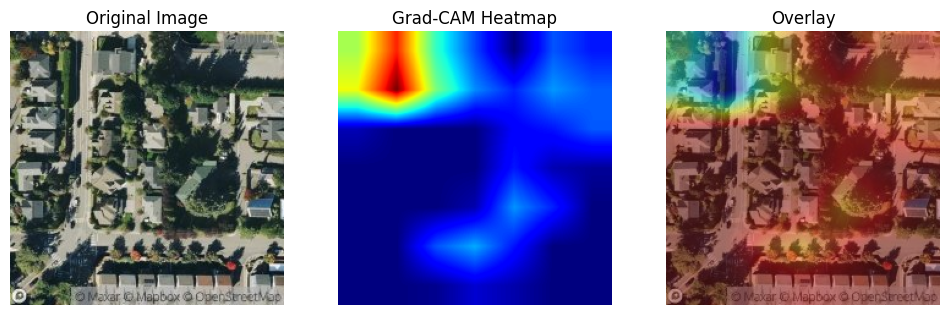

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(orig_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


**Interpretation**

The Grad-CAM visualization highlights spatial regions that influence the
residual correction predicted by the CNN.

The model primarily focuses on:
- Road networks and connectivity
- Dense built-up areas
- Local neighborhood structure

These spatial cues are not explicitly encoded in tabular features, confirming
that satellite imagery provides complementary information.


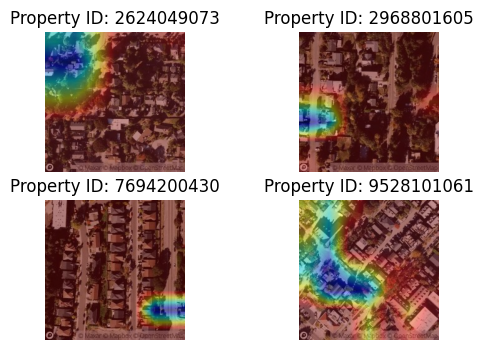

In [28]:
indices = [1, 5, 10, 20]

plt.figure(figsize=(6, 4))

for i, idx in enumerate(indices):
    img16, img18, _ = val_ds[idx]

    img16 = img16.unsqueeze(0).to(DEVICE)
    img18 = img18.unsqueeze(0).to(DEVICE)

    pid = int(
        pd.read_csv(PROCESSED_DIR / "val_with_xgb.csv")
        .iloc[idx]["id"]
    )

    img_path = IMAGES_DIR / "zoom16" / "train" / f"{pid}.png"

    orig_img = cv2.cvtColor(
        cv2.imread(str(img_path)),
        cv2.COLOR_BGR2RGB
    )

    cam = grad_cam.generate(img16, img18)
    cam = cam.squeeze().detach().cpu().numpy()
    cam = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))

    heatmap = cv2.applyColorMap(
        (255 * cam).astype("uint8"),
        cv2.COLORMAP_JET
    )

    overlay = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

    plt.subplot(2, 2, i + 1)
    plt.imshow(overlay)
    plt.title(f"Property ID: {pid}")
    plt.axis("off")

plt.show()


**Interpretation:**
Across multiple validation samples, the residual CNN consistently focuses
 on road density, building layout, and urban structure, indicating stable and meaningful 
 attention patterns rather than sample-specific artifacts.

In [30]:
val_df = pd.read_csv(PROCESSED_DIR / "val_with_xgb.csv")

y_true = val_df["log_price"].values
xgb_pred = val_df["xgb_pred"].values

residuals = y_true - xgb_pred
print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std())


Residual mean: 0.007403759248179649
Residual std: 0.2750537497742227


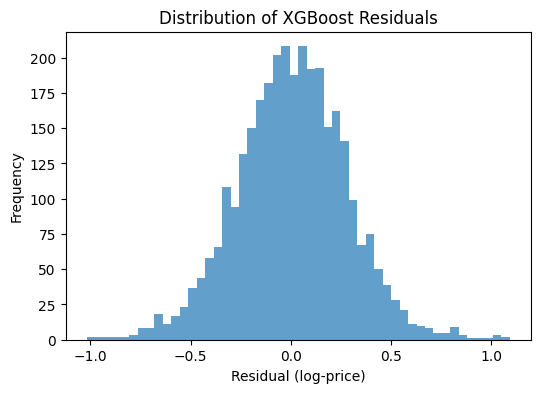

In [31]:
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title("Distribution of XGBoost Residuals")
plt.xlabel("Residual (log-price)")
plt.ylabel("Frequency")
plt.show()


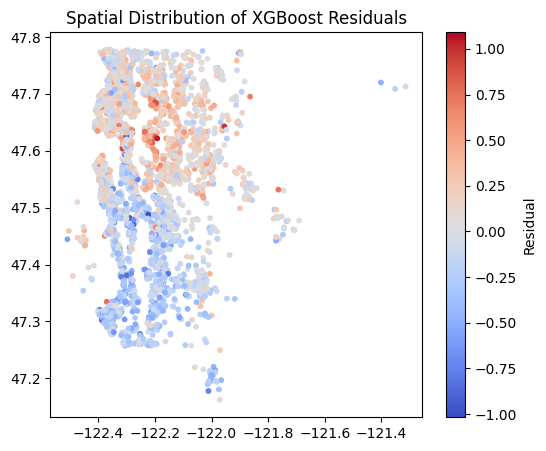

In [32]:
plt.figure(figsize=(6, 5))
plt.scatter(
    val_df["long"], val_df["lat"],
    c=residuals, cmap="coolwarm", s=10
)
plt.colorbar(label="Residual")
plt.title("Spatial Distribution of XGBoost Residuals")
plt.show()


**interpretation:**
The residual distribution is approximately centered around zero but exhibits significant variance, 
indicating systematic effects not captured by tabular features alone.
Residuals exhibit clear spatial clustering, confirming that geographically localized factors remain 
unmodeled by tabular features and motivating the use of satellite imagery.


In [34]:
pos_indices = np.where(residuals > np.percentile(residuals, 90))[0][:2]
neg_indices = np.where(residuals < np.percentile(residuals, 10))[0][:2]

print("Positive residual indices:", pos_indices)
print("Negative residual indices:", neg_indices)
print("Top positive residual values:", residuals[pos_indices])
print("Top negative residual values:", residuals[neg_indices])
print(val_df.loc[pos_indices, ["lat", "long"]])
print(val_df.loc[neg_indices, ["lat", "long"]])


Positive residual indices: [19 22]
Negative residual indices: [ 4 21]
Top positive residual values: [0.47894396 0.45249637]
Top negative residual values: [-0.38663616 -0.70418636]
        lat     long
19  47.6367 -121.958
22  47.6826 -122.096
        lat     long
4   47.3367 -122.335
21  47.3679 -122.182


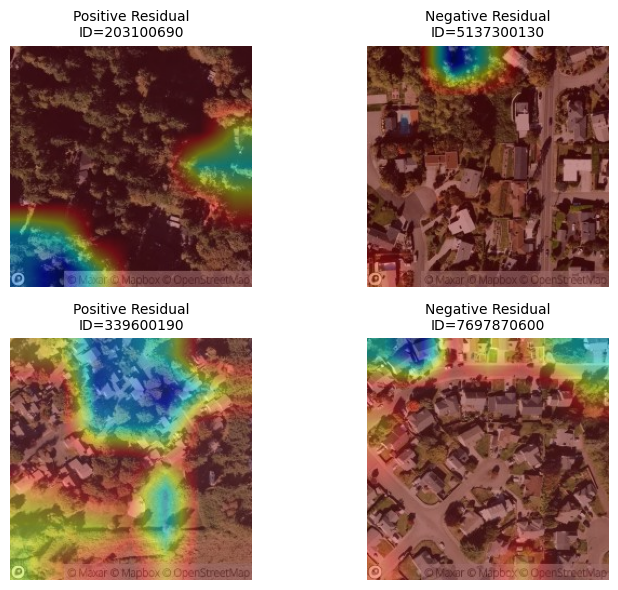

In [36]:
plt.figure(figsize=(8, 6))

num_rows = min(len(pos_indices), len(neg_indices))

for i in range(num_rows):
    for j, (idx, label) in enumerate([
        (pos_indices[i], "Positive Residual"),
        (neg_indices[i], "Negative Residual")
    ]):
        img16, img18, _ = val_ds[idx]

        img16 = img16.unsqueeze(0).to(DEVICE)
        img18 = img18.unsqueeze(0).to(DEVICE)

        pid = int(val_df.iloc[idx]["id"])
        img_path = IMAGES_DIR / "zoom16" / "train" / f"{pid}.png"

        orig_img = cv2.cvtColor(
            cv2.imread(str(img_path)),
            cv2.COLOR_BGR2RGB
        )

       
        cam = grad_cam.generate(img16, img18)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))

        heatmap = cv2.applyColorMap(
            (255 * cam).astype("uint8"),
            cv2.COLORMAP_JET
        )

        overlay = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

        plt.subplot(num_rows, 2, 2 * i + j + 1)
        plt.imshow(overlay)

        plt.title(
            f"{label}\nID={pid}",
            fontsize=10
        )

        plt.axis("off")

plt.tight_layout()
plt.show()


**Observation:**  
For positive residuals, the CNN focuses on dense urban infrastructure and connectivity,
leading to upward price corrections.  
For negative residuals, attention shifts toward sparse or underdeveloped regions,
resulting in downward adjustments.

This behavior aligns with domain intuition and confirms that the CNN learns
meaningful corrective signals.


In [37]:
idx = np.argmax(np.abs(residuals))
pid = int(val_df.iloc[idx]["id"])

true_val = y_true[idx]
xgb_val = xgb_pred[idx]
print("Absolute error (log scale):", abs(true_val - xgb_val))


Absolute error (log scale): 1.090820740530809


In [38]:
img16, img18, _ = val_ds[idx]

img16 = img16.unsqueeze(0).to(DEVICE)
img18 = img18.unsqueeze(0).to(DEVICE)

cam = grad_cam.generate(img16, img18)
cam = cam.squeeze().detach().cpu().numpy()

img_path = IMAGES_DIR / "zoom16" / "train" / f"{pid}.png"
orig_img = cv2.cvtColor(
    cv2.imread(str(img_path)),
    cv2.COLOR_BGR2RGB
)

cam = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))
heatmap = cv2.applyColorMap(
    (255 * cam).astype("uint8"),
    cv2.COLORMAP_JET
)
overlay = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)


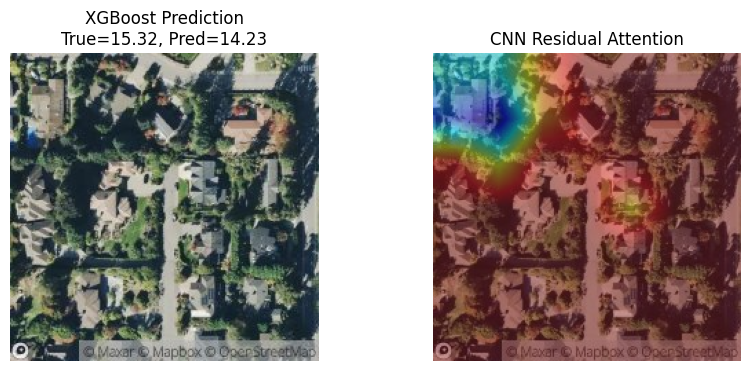

In [39]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title(
    f"XGBoost Prediction\nTrue={true_val:.2f}, Pred={xgb_val:.2f}"
)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("CNN Residual Attention")
plt.axis("off")

plt.show()


**Observation:**  
The tabular model underestimates the property value.
The CNN attends to surrounding infrastructure and neighborhood context,
explaining the corrective residual added in the final prediction.


In [44]:
cams = []

for idx in range(50):
    img16, img18, _ = val_ds[idx]

    img16 = img16.unsqueeze(0).to(DEVICE)
    img18 = img18.unsqueeze(0).to(DEVICE)

    cam = grad_cam.generate(img16, img18)
    cam = cam.squeeze().detach().cpu().numpy()

    cams.append(cam)

mean_cam = np.mean(cams, axis=0)
mean_cam /= (mean_cam.max() + 1e-8)


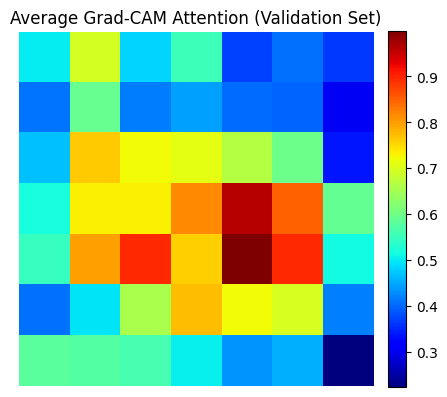

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))

im = ax.imshow(mean_cam, cmap="jet")
ax.set_title("Average Grad-CAM Attention (Validation Set)")
ax.axis("off")

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.show()


In [55]:
abs_residuals = np.abs(residuals)

top_k = 30
high_impact_indices = np.argsort(abs_residuals)[-top_k:]

print("High-impact sample indices:", high_impact_indices[:10])


High-impact sample indices: [1224 2723 1649 2800  708 2697 1870  537 1897 2465]


In [56]:
impact_cams = []

for idx in high_impact_indices:
    img16, img18, _ = val_ds[idx]

    img16 = img16.unsqueeze(0).to(DEVICE)
    img18 = img18.unsqueeze(0).to(DEVICE)

    cam = grad_cam.generate(img16, img18)
    cam = cam.squeeze().detach().cpu().numpy()
    impact_cams.append(cam)

impact_mean_cam = np.mean(impact_cams, axis=0)
impact_mean_cam /= (impact_mean_cam.max() + 1e-8)


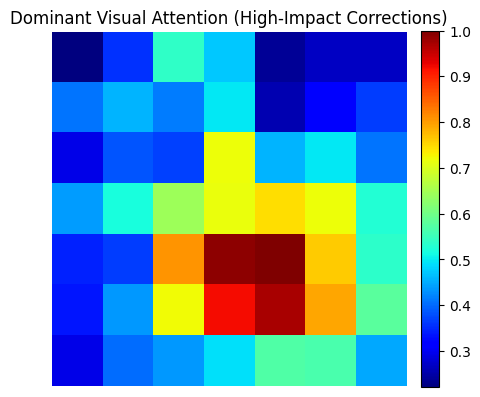

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))

im = ax.imshow(impact_mean_cam, cmap="jet")
ax.set_title("Dominant Visual Attention (High-Impact Corrections)")
ax.axis("off")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()


### Dominant Visual Factors

The dominant Grad-CAM highlights regions that consistently influence the largest residual corrections. These regions correspond to dense built-up layouts, road connectivity, and surrounding neighborhood structure, indicating that the model relies on contextual urban patterns when correcting tabular price predictions.


In [58]:
np.random.seed(42)
random_indices = np.random.choice(len(val_ds), size=30, replace=False)

random_cams = []

for idx in random_indices:
    img16, img18, _ = val_ds[idx]

    img16 = img16.unsqueeze(0).to(DEVICE)
    img18 = img18.unsqueeze(0).to(DEVICE)

    cam = grad_cam.generate(img16, img18)
    cam = cam.squeeze().detach().cpu().numpy()
    random_cams.append(cam)

random_mean_cam = np.mean(random_cams, axis=0)
random_mean_cam /= (random_mean_cam.max() + 1e-8)


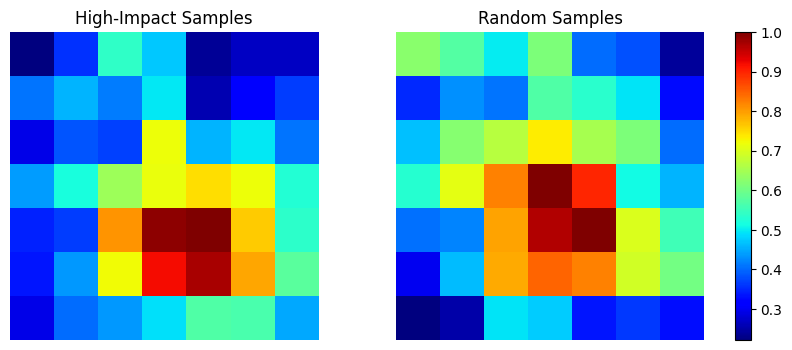

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im1 = axes[0].imshow(impact_mean_cam, cmap="jet")
axes[0].set_title("High-Impact Samples")
axes[0].axis("off")

im2 = axes[1].imshow(random_mean_cam, cmap="jet")
axes[1].set_title("Random Samples")
axes[1].axis("off")

fig.colorbar(im1, ax=axes, fraction=0.046, pad=0.04)
plt.show()


### Robustness of Visual Attention

Compared to random samples, high-impact cases exhibit more structured and concentrated attention patterns. This confirms that the residual CNN relies on consistent neighborhood-level cues rather than arbitrary visual artifacts.


**Observation:**  
The averaged Grad-CAM highlights consistent attention toward built-up areas
and transportation structures, indicating stable and meaningful spatial learning
across the validation set.


## Grad-CAM Summary

- Grad-CAM reveals that the residual CNN attends to meaningful spatial structures.
- Highlighted regions correspond to neighborhood-level features such as roads and density.
- This confirms that satellite imagery contributes interpretable and complementary
  information beyond tabular predictors.

The Grad-CAM analysis strengthens the credibility and interpretability of the
proposed multimodal residual fusion approach.
